In [30]:
import json
from urllib.request import urlopen
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats
from collections import Counter
from scipy.optimize import curve_fit
from scipy import stats
#plt.style.use('seaborn')
plt.style.use(['science', 'notebook'])

def annotate_bars(ax):
    for p in ax.patches:
        ax.annotate('{}'.format(p.get_height()), (p.get_x()+p.get_width()/2, p.get_height()),
                   bbox={'facecolor': 'white', 'alpha': 1, 'pad': 1}, ha='center', fontsize=10)

def get_ci_manual(t, s_err, n, x, x2, y2, ax=None):  
    ci = t * s_err * np.sqrt(1/n + (x2 - np.mean(x))**2 / np.sum((x - np.mean(x))**2))
    return ci

def line(x, m, b):
    return m*x+b

def get_line_and_CI(x,y,yerr):
    # Get data
    xdata = x[y>0]
    ydata = y[y>0]
    yerrdata = yerr[y>0]
    # Fit to Curve
    popt, pcov = curve_fit(line, xdata, ydata, sigma=yerrdata)
    xfit = np.linspace(np.min(xdata), np.max(xdata), 100)
    yfit = line(xfit, popt[0], popt[1])
    # Statistics
    NN = yfit.size
    NP = 2               
    dof = NN - NP                   
    t = stats.t.ppf(0.975, NN - NP)  
    # Estimates of Error in Data/Model
    y_model = m*xdata + b
    resid = ydata - y_model                                                           
    s_err = np.sqrt(np.sum(resid**2) / dof)
    # Confidence Interval
    ci = get_ci_manual(t, s_err, NN, xdata, xfit, yfit)
    return xdata, ydata, xfit, yfit, ci, popt, pcov

* Gender
* Change Kupura to female
* Award Recipients Y axis
* X axis all labels
* 2019-2021 all societies

In [2]:
award_cnt_label='Total Number of Award Recipients'

In [3]:
df = pd.read_csv('master2_withpred.csv', delimiter=',')

In [4]:
df['male'] = df['Gender']=='1'
df['female'] = df['Gender']=='2'
df['male_p'] = df['pred_gender']=='male'
df['female_p'] = df['pred_gender']=='female'
df = df[['Year', 'male', 'female', 'male_p', 'female_p', 'Society']]
df = df.dropna()

In [5]:
df['has_gender'] = df['male']+df['female']
df['has_gender_p'] = df['male_p']+df['female_p']
df.loc[~df.has_gender&df.has_gender_p&df.male_p, 'male'] = True
df.loc[~df.has_gender&df.has_gender_p&df.female_p, 'female'] = True
df = df[df.Year != 'Current fellows']
df.Year = df.Year.astype(float)

C:\Users\lukep\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:203: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  warnings.warn(


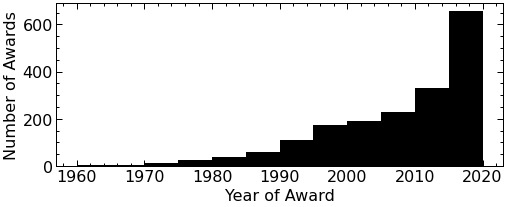

In [6]:
bins = np.arange(1960, 2025, 5)
plt.figure(figsize=(8,3))
plt.hist(df.Year.astype(float), bins=bins, color='k')
plt.xlabel('Year of Award')
plt.ylabel('Number of Awards')
plt.show()

Obtain years and year labels in segments of every 5 years and put them as an additional column to the dataframe

In [7]:
years = np.zeros(df.shape[0])
year_labels = np.zeros(df.shape[0]).astype(str)
groupings = np.arange(1950, 2030, 5)
for i in range(len(groupings)-1):
    years[(df.Year<groupings[i+1]).values * (df.Year>=groupings[i]).values] = (groupings[i+1] + groupings[i])/2
    year_labels[(df.Year<groupings[i+1]).values * (df.Year>=groupings[i]).values] = f'{groupings[i]}-{groupings[i+1]}'
df['TP'] = years
df['TP_l'] = year_labels

Obtain proportion of female recipients in these 5 year segments for

* A) All societies together
* B) Seperate Societies

In [41]:
dfmw = df.groupby(['Society', 'TP_l']).sum().unstack(fill_value=0).stack()[['male', 'female']].iloc[0:].reset_index()
dfmw['tot'] = dfmw['male'] + dfmw['female']
dfmw = dfmw[dfmw.tot!=0]
# All societies together
dfmw_all = dfmw.groupby(['TP_l']).sum()
#Get p values
dfmw['p'] = dfmw['female']/dfmw['tot']
dfmw_all['p'] = dfmw_all['female']/dfmw_all['tot']

dfmw['TP'] = (dfmw['TP_l'].map(lambda x: float(x[0:4])) + dfmw['TP_l'].map(lambda x: float(x[5:])))/2
dfmw_all['TP'] = (dfmw_all.index.map(lambda x: float(x[0:4])) + dfmw_all.index.map(lambda x: float(x[5:])))/2

All societies together

In [42]:
x_l = list(dfmw_all.index)
x = dfmw_all.TP.values
y = dfmw_all.p.values
n = dfmw_all.tot.values
yerr = np.sqrt(y*(1-y)/n)

Fit data to best fit line and get the confidence interval

In [43]:
xdata, ydata, xfit, yfit, ci, popt, pcov = get_line_and_CI(x,y,yerr)
m, m_err = popt[0], np.sqrt(pcov[0,0])

Show plot

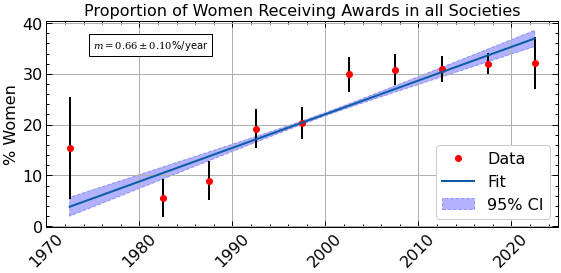

In [44]:
fig, ax = plt.subplots(figsize=(8,4), facecolor='white')
plt.title('Proportion of Women Receiving Awards in all Societies')
plt.errorbar(xdata,100*ydata,yerr=100*yerrdata, color='k', ls='')
plt.plot(xdata,100*ydata, 'o', color='r', label='Data')
plt.plot(xdata, 100*(m*xdata+b), label='Fit')
plt.fill_between(xfit, 100*(yfit + ci), 100*(yfit - ci), color="blue", linestyle="--", alpha=0.3, label='95% CI')
plt.ylabel('% Women')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.text(1975, 35, f'$m={100*m:.2f}\pm{100*m_err:.2f}$%/year', bbox=dict(facecolor='white', edgecolor='k'))
plt.legend(loc='lower right', facecolor='white', framealpha=1, frameon=True)
plt.savefig('plots_rad/all_societies.png',dpi=200)
plt.show()

Stuff having to do with societies.

In [291]:
societies = df['Society'].unique().astype(str)

In [294]:
i=6
x = dfmw[dfmw.Society==societies[i]].TP_l.values
y = dfmw[dfmw.Society==societies[i]].p.values
n = dfmw[dfmw.Society==societies[i]].tot.values
yerr = np.sqrt(y*(1-y)/n)

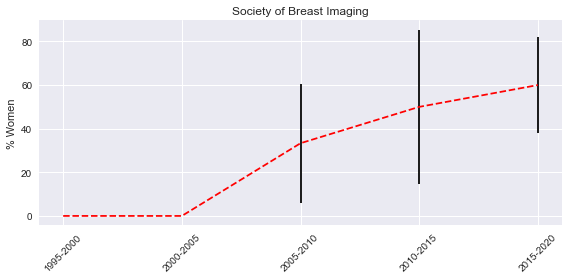

In [295]:
plt.figure(figsize=(8,4))
plt.title(societies[i])
plt.plot(x,100*y, color='r', ls='--')
plt.errorbar(x,100*y,yerr=100*yerr, color='k', ls='')
plt.ylabel('% Women')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('plots_rad/sample_society.png',dpi=200)
plt.show()

# Extra (OBtaining Genders From Website)

In [15]:
def get_genders(names):
    pred_genders = []
    myKey = "JljB4rjnA72npkDnX9kBzqVneqV8BQZRU2Zz"
    for name in names:
        url = "https://gender-api.com/get?key=" + myKey + "&split={}".format(name)
        response = urlopen(url)
        decoded = response.read().decode('utf-8')
        data = json.loads(decoded)
        pred_genders.append(data['gender'])
    return pred_genders

def remove_char(arr, char):
    return ' '.join(list(filter(lambda x:char not in x, arr.split())))

In [16]:
df = pd.read_csv('radio_master.csv')

In [17]:
arr = df['Name'].to_numpy()
arr = np.array([a.split(',')[0] for a in arr])
arr = np.array([a.split(':')[-1] for a in arr])
arr = np.vectorize(remove_char)(arr, '*')
arr = np.vectorize(remove_char)(arr, '.')
arr = np.vectorize(remove_char)(arr, '(')

f_name = [a.split(' ')[0] for a in arr]
l_name = [a.split(' ')[-1] for a in arr]

f_name = [f.encode() for f in f_name]
l_name = [l.encode() for l in l_name]

In [39]:
pred_genders = get_genders(df['FName'].values)

In [40]:
df['pred_genders'] = pred_genders
df.to_csv('gender_data_predicted.csv')

In [41]:
df

,Society,Award Type,Year,Award Winner,Training Level,Gender,Male,Female,FName,LName,pred_genders
0,COS,3,2021,Brian Leonard,1,1,True,False,Brian,Leonard,male
1,COS,3,2020,Simon Holland,1,1,True,False,Simon,Holland,male
2,COS,3,2019,Helene Boisjoly,1,2,False,True,Helene,Boisjoly,female
3,COS,3,2018,Graham Trope,3,1,True,False,Graham,Trope,male
4,COS,3,2017,Seymour Brownstein,1,1,True,False,Seymour,Brownstein,male
...,...,...,...,...,...,...,...,...,...,...,...
220,EPS,3,2013,Jeff Sher,1,1,True,False,Jeff,Sher,male
221,EPS,3,2012,Jeff Hurwitz,1,1,True,False,Jeff,Hurwitz,male
222,EPS,3,2011,John Fowler,1,1,True,False,John,Fowler,male
223,EPS,1,2017,John Fowler,1,1,True,False,John,Fowler,male


In [383]:
import statsmodels.api as sm

In [397]:
X = sm.add_constant(xfit)
Y = yfit
W = 1/yerrfit**2

In [398]:
results = sm.WLS(Y, X, weights=W).fit()

In [399]:
results.summary()

C:\Users\lukep\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.848
Model:                            WLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     44.47
Date:                Thu, 02 Dec 2021   Prob (F-statistic):           0.000158
Time:                        21:13:47   Log-Likelihood:                 18.143
No. Observations:                  10   AIC:                            -32.29
Df Residuals:                       8   BIC:                            -31.68
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -13.0429      1.994     -6.540      0.000     -17.642      -8.444
x1             0.0066      0.001      6.668      0.000       0.004       0.009
==============================================================================
Omnibus:                        1.809   Durbin-Watson:                   1.376
Prob(Omnibus):                  0.405   Jarque-Bera (JB):                0.817
Skew:                           0.156   Prob(JB):                        0.665
Kurtosis:                       1.635   Cond. No.                     3.27e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.27e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""